In [1]:
path_ = 'C:/Users/Paul/Desktop/MSc DSBA/1. Big Data Analytics/1. Project/Github/Cleaned Data/'

### Importing packages

In [2]:
from os import listdir
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
#from tqdm import tqdm as prog_bar

pd.options.mode.chained_assignment =None

In [3]:
print(listdir(path_))

['featured_data.csv', 'full_daily_data.csv', 'full_data.csv', 'full_hourly_data.csv', 'holidays.csv', 'hourly_full_data.csv', 'log.txt', 'log_year.txt', 'stations.csv', 'Weather Data']


### Loading data

In [4]:
df = pd.read_csv(path_ + 'full_data.csv').drop(['cnt', 'casual', 'registered', 'wkday'], axis = 1)
df_hour = pd.read_csv(path_ + 'full_daily_data.csv')
df = pd.merge(left = df, right = df_hour, on =  ['year', 'month', 'day'], how = 'outer')

### Cosine distance feature engineering

In [5]:
#df['hr_sin'] = np.sin(df.hour*(2.*np.pi/24))
#df['hr_cos'] = np.cos(df.hour*(2.*np.pi/24))
df['wkday_sin'] = np.sin(df.weekday*(2.*np.pi/7))
df['wkday_cos'] = np.cos(df.weekday*(2.*np.pi/7))
df['sunrise_sin'] = np.sin(df.sunrise*(2.*np.pi/24))
df['sunrise_cos'] = np.cos(df.sunrise*(2.*np.pi/24))
df['sunset_sin'] = np.sin(df.sunset*(2.*np.pi/24))
df['sunset_cos'] = np.cos(df.sunset*(2.*np.pi/24))
df['mnth_sin'] = np.sin((df.month-1)*(2.*np.pi/12))
df['mnth_cos'] = np.cos((df.month-1)*(2.*np.pi/12))
df['light'] = (-df.sunrise + df.sunset)

In [6]:
df.head()

,index,max_temp,min_temp,wind_speed,wind_temp,rain,hum,visibility,clouds,chaleur_index,...,cnt,wkday_sin,wkday_cos,sunrise_sin,sunrise_cos,sunset_sin,sunset_cos,mnth_sin,mnth_cos,light
0,2010-09-15,29.0,17.0,2.222222,17.0,0.0,0.72,10.000,7.0,29.0,...,1,0.433884,-0.900969,0.965926,0.258819,-1.0,-1.836970e-16,-0.866025,-0.5,13.0
1,2010-09-16,31.0,17.0,4.444444,17.0,1.0,0.93,8.750,46.0,31.0,...,1,-0.433884,-0.900969,0.965926,0.258819,-1.0,-1.836970e-16,-0.866025,-0.5,13.0
2,2010-09-17,25.0,18.0,4.166667,18.0,2.0,0.95,9.625,24.0,26.0,...,9,-0.974928,-0.222521,0.965926,0.258819,-1.0,-1.836970e-16,-0.866025,-0.5,13.0
3,2010-09-19,29.0,16.0,1.388889,16.0,NaN,0.80,10.000,10.0,29.0,...,11,-0.781831,0.623490,0.965926,0.258819,-1.0,-1.836970e-16,-0.866025,-0.5,13.0
4,2010-09-20,25.0,16.0,5.000000,16.0,NaN,0.83,10.000,10.0,25.0,...,238,0.000000,1.000000,0.965926,0.258819,-1.0,-1.836970e-16,-0.866025,-0.5,13.0


In [7]:
weather_col = ['max_temp', 'min_temp', 'wind_speed', 'wind_temp', 'rain', 'hum',
       'visibility', 'clouds', 'chaleur_index', 'rosee', 'pressure', 'sunrise',
       'sunset', 'light']
time_col = ['holiday', 'weekday', 'workday', 'avg_temp', 'atemp', 'wkday',
            #'hr_sin', 'hr_cos', 
            'wkday_sin', 'wkday_cos',
       'sunrise_sin', 'sunrise_cos', 'sunset_sin', 'sunset_cos', 'mnth_sin',
       'mnth_cos', 'year']
target_col = ['casual',
       'registered', 'cnt']

In [8]:
def na_values_compute(df):
    na_values = {}
    for col in df.columns:
        na_values[col] = sum(pd.isnull(df[col]))
    return na_values

In [9]:
na_values_compute(df)

{'atemp': 31,
 'avg_temp': 31,
 'casual': 0,
 'chaleur_index': 58,
 'clouds': 33,
 'cnt': 0,
 'day': 0,
 'holiday': 31,
 'hum': 31,
 'index': 31,
 'light': 31,
 'max_temp': 45,
 'min_temp': 33,
 'mnth_cos': 0,
 'mnth_sin': 0,
 'month': 0,
 'pressure': 31,
 'rain': 417,
 'registered': 0,
 'rosee': 160,
 'string_date': 0,
 'sunrise': 31,
 'sunrise_cos': 31,
 'sunrise_sin': 31,
 'sunset': 31,
 'sunset_cos': 31,
 'sunset_sin': 31,
 'visibility': 31,
 'weekday': 31,
 'wind_speed': 31,
 'wind_temp': 32,
 'wkday': 0,
 'wkday_cos': 31,
 'wkday_sin': 31,
 'workday': 31,
 'year': 0}

In [10]:
# we drop the atemp == NA observations: those are totally null observations
df = df[df.atemp.notnull()]
df = df.set_index(['year', 'month', 'day'])

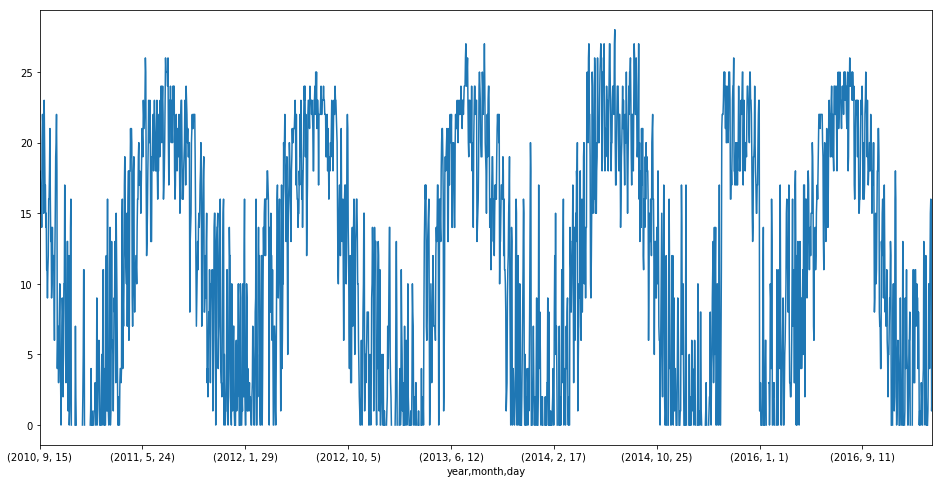

In [11]:
df['rosee'].plot(figsize = (16,8))
plt.show()

In [12]:
# we can see that the rosee variable is pretty cyclic so we can interpolate it to fill the na values
df.rosee = df.rosee.interpolate()

In [13]:
na_values_compute(df)

{'atemp': 0,
 'avg_temp': 0,
 'casual': 0,
 'chaleur_index': 27,
 'clouds': 2,
 'cnt': 0,
 'holiday': 0,
 'hum': 0,
 'index': 0,
 'light': 0,
 'max_temp': 14,
 'min_temp': 2,
 'mnth_cos': 0,
 'mnth_sin': 0,
 'pressure': 0,
 'rain': 386,
 'registered': 0,
 'rosee': 0,
 'string_date': 0,
 'sunrise': 0,
 'sunrise_cos': 0,
 'sunrise_sin': 0,
 'sunset': 0,
 'sunset_cos': 0,
 'sunset_sin': 0,
 'visibility': 0,
 'weekday': 0,
 'wind_speed': 0,
 'wind_temp': 1,
 'wkday': 0,
 'wkday_cos': 0,
 'wkday_sin': 0,
 'workday': 0}

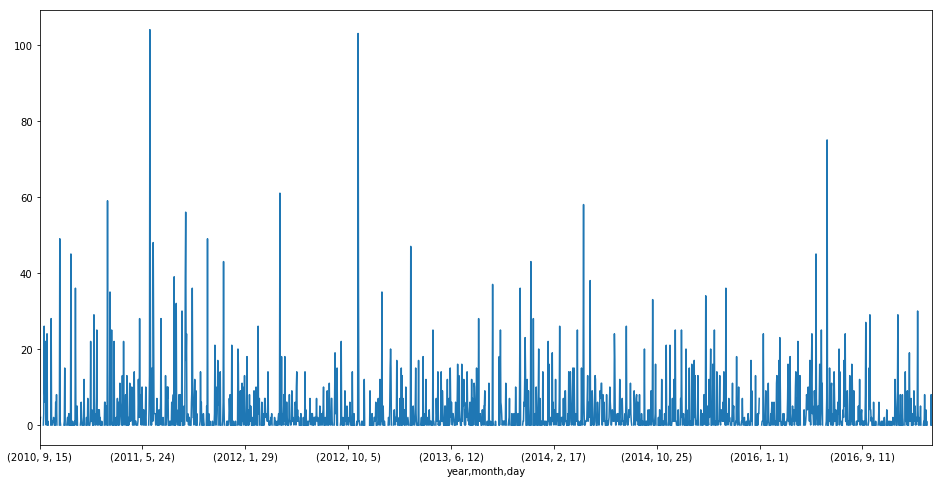

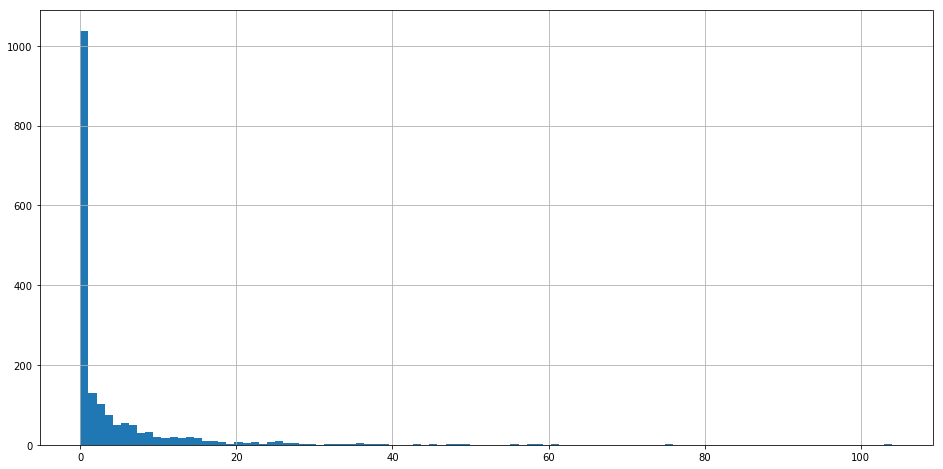

In [14]:
df.rain.plot(figsize = (16,8))
plt.show()
# there is no clear pattern. let's see the distribution
df.rain.hist(figsize = (16,8), bins=100)
plt.show()

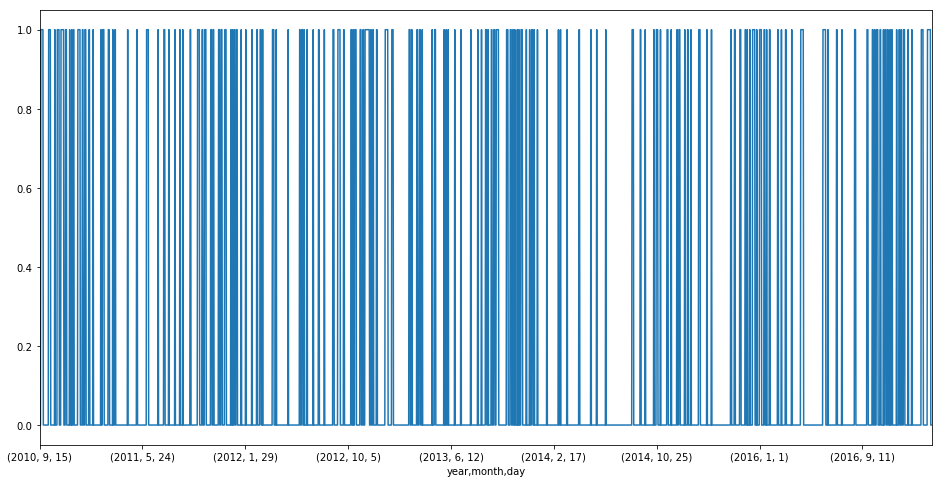

In [15]:
df['missing_rain'] = pd.isnull(df.rain)
df['missing_rain'].plot(figsize = (16,8))
plt.show()
# we can see from those two graphs that missing rain data is not localized. Moreover its distribution is very skewed toward 0. 
# we are going to use the mean value of the rain variable for each month in order not to change too much the data

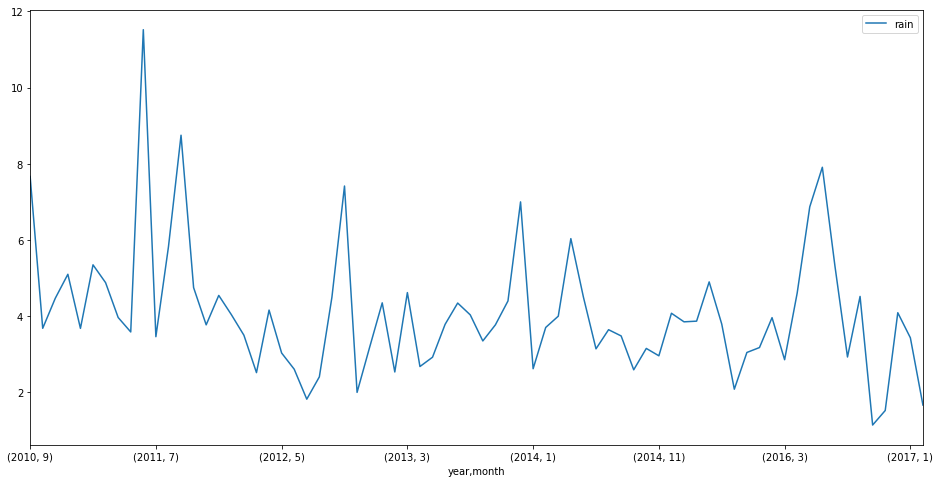

In [16]:
df_missing_rain = df['rain'].dropna().reset_index().drop(['day'], axis = 1)
df_missing_rain = df_missing_rain.groupby(['year', 'month']).mean()
df_missing_rain.head()
df_missing_rain.plot(figsize = (16,8))
plt.show()

In [17]:
df_missing_rain.columns = ['mean_rain']
df = df.reset_index()
df_missing_rain = df_missing_rain.reset_index()

df = pd.merge(left = df, right = df_missing_rain, on = ['year', 'month'], how = 'left')
df = df.set_index(['year', 'month', 'day'], drop = False)
df = df.drop(['month', 'day'], axis = 1)
del df_missing_rain

df['rain'][df['missing_rain']] = df['mean_rain'][df['missing_rain']]

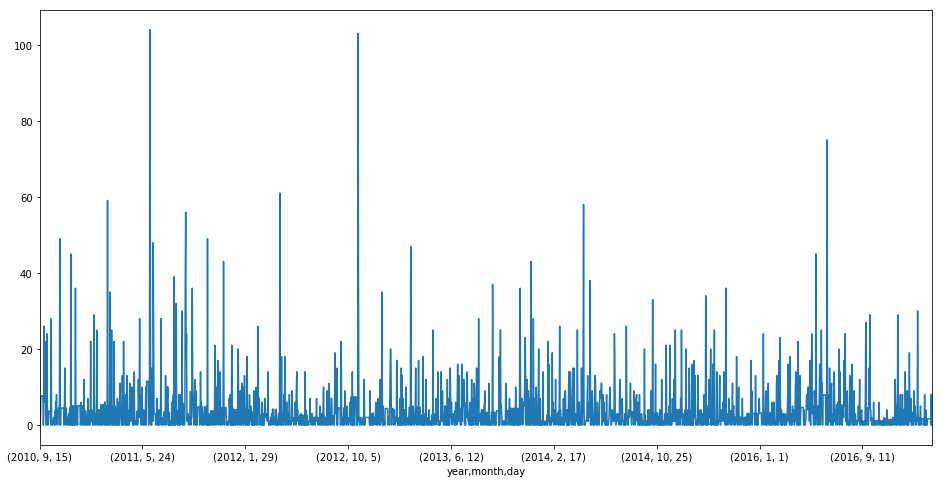

In [18]:
df['rain'].plot(figsize = (16,8))
plt.show()

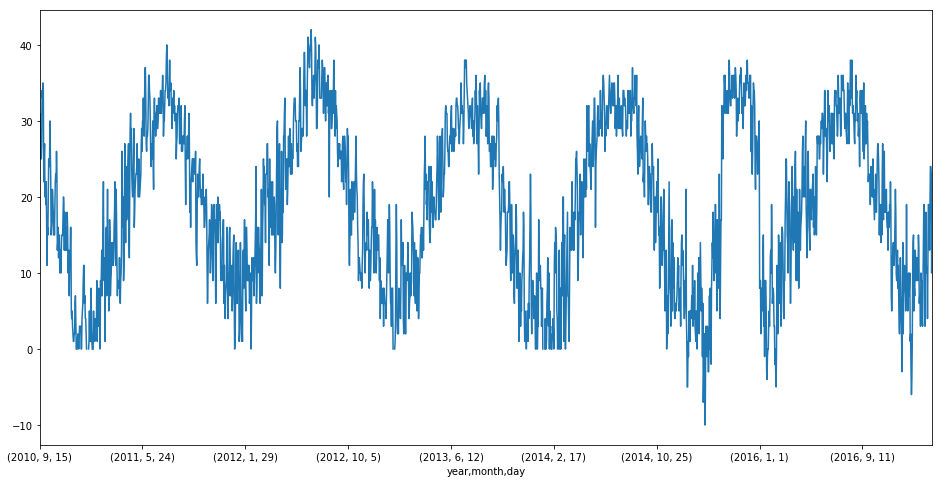

In [19]:
df['max_temp'].plot(figsize = (16,8))
plt.show()
# once again it is very cyclic so we are going to interpolate it

In [20]:
df.max_temp = df.max_temp.interpolate()
df.min_temp = df.min_temp.interpolate() # we do the same for min_temp

In [21]:
# recomputing avg_temp
df['avg_temp'] =(df['max_temp'] + df['min_temp'])/2

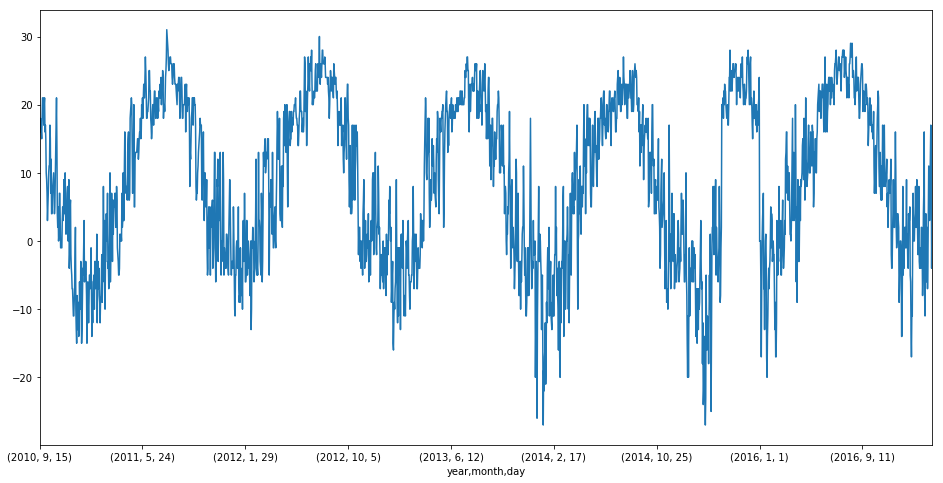

In [22]:
df.wind_temp.plot(figsize = (16,8))
plt.show()
# once again, interpolating (also there is only one missing day...)
df['wind_temp'] = df['wind_temp'].interpolate()

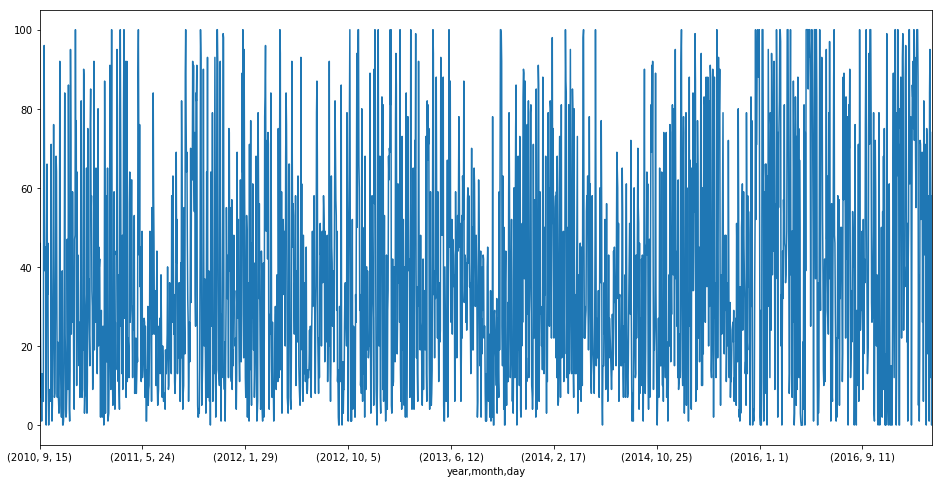

In [23]:
df.clouds.plot(figsize = (16,8))
plt.show()

In [24]:
print(sum(pd.isnull(df.clouds))/24)
# There are only two days missing so we are going to interpolate, 
# assuming that the clouds are almost the same from one day to another
df.clouds = df.clouds.interpolate()

0.0833333333333


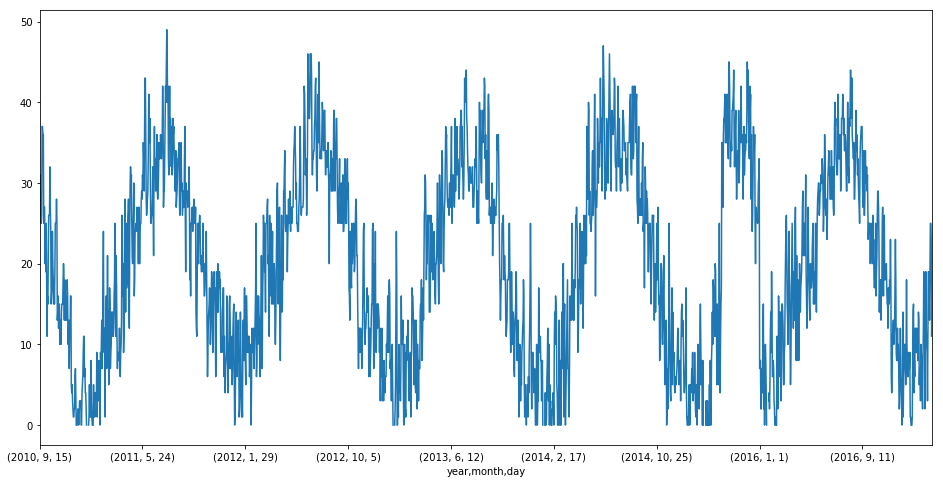

In [25]:
df.chaleur_index.plot(figsize = (16,8))
plt.show()

In [26]:
# Once again...
df.chaleur_index = df.chaleur_index.interpolate()

In [27]:
df.head()

year       index  max_temp  min_temp  wind_speed  wind_temp  \
year month day                                                                
2010 9     15   2010  2010-09-15      29.0      17.0    2.222222       17.0   
           16   2010  2010-09-16      31.0      17.0    4.444444       17.0   
           17   2010  2010-09-17      25.0      18.0    4.166667       18.0   
           19   2010  2010-09-19      29.0      16.0    1.388889       16.0   
           20   2010  2010-09-20      25.0      16.0    5.000000       16.0   

                    rain   hum  visibility  clouds    ...     wkday_cos  \
year month day                                        ...                 
2010 9     15   0.000000  0.72      10.000     7.0    ...     -0.900969   
           16   1.000000  0.93       8.750    46.0    ...     -0.900969   
           17   2.000000  0.95       9.625    24.0    ...     -0.222521   
           19   7.666667  0.80      10.000    10.0    ...      0.623490   
           20   7.666667  0.83      10.000    10.0    ...      1.000000   

                sunrise_sin  sunrise_cos  sunset_sin    sunset_cos  mnth_sin  \
year month day                                                                 
2010 9     15      0.965926     0.258819        -1.0 -1.836970e-16 -0.866025   
           16      0.965926     0.258819        -1.0 -1.836970e-16 -0.866025   
           17      0.965926     0.258819        -1.0 -1.836970e-16 -0.866025   
           19      0.965926     0.258819        -1.0 -1.836970e-16 -0.866025   
           20      0.965926     0.258819        -1.0 -1.836970e-16 -0.866025   

                mnth_cos  light  missing_rain mean_rain  
year month day                                           
2010 9     15       -0.5   13.0         False  7.666667  
           16       -0.5   13.0         False  7.666667  
           17       -0.5   13.0         False  7.666667  
           19       -0.5   13.0          True  7.666667  
           20       -0.5   13.0          True  7.666667  

[5 rows x 36 columns]

In [28]:
df.to_csv(path_ + 'featured_daily_data.csv', index = True, encoding='utf-8')